## Attempt DeepLabV3+ for land clf
gsutil -m cp "gs://terrakio-mass-requests/KG7zkkvurzSh23Ue70C5k7groNy2/rgb23_large1/data/ver1/*" /home/haizea-gpu-machine-1/Desktop/actclf/2015lab_samples/labels/trainingImages/

In [1]:
import xarray as xr
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import seaborn as sns

from skl2onnx import to_onnx
from onnxruntime import InferenceSession

import os
import math

from torch import nn
from torch.nn import functional as F
from torch.optim import Adam, AdamW, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import GradScaler
import time

from torch.nn import ReLU, Sigmoid
from torch.nn import Module, Sequential 
from torch.nn import Conv3d, ConvTranspose3d, BatchNorm3d, MaxPool3d, AvgPool1d
import random

from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, mean_squared_error, r2_score
from sklearn.utils.class_weight import compute_class_weight

In [2]:
class LocalDataset(Dataset):
    '''Read samples from a local directory'''
    def __init__(self, rgb_dir, label_dir, file_names, crop_size=None):
        self.rgb_dir = rgb_dir
        self.label_dir = label_dir
        self.file_names = file_names
        self.crop_size = crop_size

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        input_data, target_data = self.load_data(self.file_names[idx])
        if self.crop_size is not None:
            input_data = input_data.isel(x=slice(0, self.crop_size), 
                                       y=slice(0, self.crop_size))

            target_data = target_data.isel(x=slice(0, self.crop_size), 
                                         y=slice(0, self.crop_size))
        return {'inputs': input_data, 'target': target_data}

    def load_data(self, file_name):
        rgb_path = os.path.join(self.rgb_dir, file_name)
        label_path = os.path.join(self.label_dir, file_name)
        
        with xr.open_dataset(rgb_path) as rgb:
            # Stack RGB channels
            input_data = rgb[['var0', 'var1', 'var2']]
        
        with xr.open_dataset(label_path) as label:
            target_array = label.label.values
            target_array = target_array[np.newaxis, ...] 
            
            # Convert to xarray DataArray
            target_data = xr.DataArray(
                target_array,
                dims=['channel', 'x', 'y'],
                name='label'
            ).to_dataset()
            
        return input_data, target_data

def custom_collate(batch):
    """
    Custom collate function to handle xarray DataArrays in the batch using np.concatenate.
    """
    batch_inputs = [np.expand_dims(sample['inputs'].to_array().values, axis=0) for sample in batch]
    batch_targets = [np.expand_dims(sample['target'].to_array().values, axis=0) for sample in batch]
    # Concatenate and return tensors
    batch_inputs = np.concatenate(batch_inputs, axis=0)
    batch_targets = np.concatenate(batch_targets, axis=0)
    #print('batch inputs', batch_inputs)
    batch_inputs = torch.tensor(batch_inputs)
    batch_targets = torch.tensor(batch_targets)
    return {'inputs': batch_inputs, 'target': batch_targets}


rgb_dir = '/home/haizea-gpu-machine-1/Desktop/actclf/2015lab_samples/labels/trainingImages23'
label_dir = '/home/haizea-gpu-machine-1/Desktop/actclf/2015lab_samples/labels/trainingLabels'
file_names = [f for f in os.listdir(label_dir) if f.endswith('.nc')]
train_size = 1600
val_size = 300
test_size = 300
batch_size = 8
crop_size = 512

np.random.seed(12)
np.random.shuffle(file_names)
train_files = file_names[:train_size]
val_files = file_names[train_size:train_size + val_size]
test_files = file_names[train_size + val_size:train_size + val_size + test_size]

# Create datasets
train_ds = LocalDataset(rgb_dir, label_dir, train_files, crop_size=crop_size)
val_ds = LocalDataset(rgb_dir, label_dir, val_files, crop_size=crop_size)
test_ds = LocalDataset(rgb_dir, label_dir, test_files, crop_size=crop_size)

# Create dataloaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle = True, num_workers=4, collate_fn=custom_collate)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle = True, num_workers=4, collate_fn=custom_collate)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle = True, num_workers=4, collate_fn=custom_collate)

In [5]:
def compute_dataset_class_weights(dataset, num_classes=8):
    # Initialize array to store all labels
    all_labels = []
    
    # Loop through dataset
    for i in tqdm(range(len(dataset)), desc="Computing class weights"):
        sample = dataset[i]
        target = sample['target'].to_array().values
        
        # Flatten the target array and add to list
        all_labels.extend(target.flatten())
    
    # Convert to numpy array
    all_labels = np.array(all_labels)
    
    # Compute class weights
    classes = np.arange(num_classes)  # [0, 1, 2, 3, 4, 5, 6, 7]
    class_weights = compute_class_weight('balanced', 
                                       classes=np.unique(all_labels), 
                                       y=all_labels)
    
    # Convert to tensor
    class_weights = torch.tensor(class_weights)
    
    return class_weights

# Compute weights using training dataset
class_weights = compute_dataset_class_weights(train_ds)
print("Class weights:", class_weights)

Computing class weights: 100%|██████████| 1600/1600 [00:19<00:00, 80.26it/s]


Class weights: tensor([7.4524, 0.5512, 1.8861, 0.5153, 1.0477, 5.3341, 0.6951],
       dtype=torch.float64)


In [3]:
from preprocessor_meta import PreprocessorTemp
preprocessor = PreprocessorTemp()

# from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation import deeplabv3_resnet101
class DeepLabV3CLF(nn.Module):
    def __init__(self, num_classes=8, pretrained=True):
        super(DeepLabV3CLF, self).__init__()
        # Load pretrained DeepLabV3+
        self.model = deeplabv3_resnet101(pretrained=pretrained)
        
        # Modify the input layer to accept 3 channels (RGB)
        # The default pretrained model already expects 3 channels, so no modification needed
        
        # Modify the classifier to output your number of classes
        self.model.classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=1)
        
    def forward(self, x):
        # DeepLabV3+ returns a dict with 'out' key
        result = self.model(x)
        return result['out']


from test_funcs import train_deeplabv3  

In [4]:
model = DeepLabV3CLF(num_classes=8, pretrained=True)
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

inputs, predictions, targets = train_deeplabv3(
    model=model,
    preprocessor=preprocessor,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    num_epochs=50,
    device=device,
    weights=True
)

/home/haizea-gpu-machine-1/miniconda3/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/haizea-gpu-machine-1/miniconda3/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/haizea-gpu-machine-1/Desktop/actclf/test_funcs.py:118: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/home/haizea-gpu-machine-1/miniconda3/envs/fastai/lib/p

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 1.7548


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [1/50], Validation Loss: 1.4482
New best model saved with validation loss: 1.4482


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2/50], Train Loss: 1.3978


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [2/50], Validation Loss: 1.2621
New best model saved with validation loss: 1.2621


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3/50], Train Loss: 1.2400


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [3/50], Validation Loss: 1.1660
New best model saved with validation loss: 1.1660


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4/50], Train Loss: 1.1581


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [4/50], Validation Loss: 1.1284
New best model saved with validation loss: 1.1284


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5/50], Train Loss: 1.0915


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [5/50], Validation Loss: 1.0945
New best model saved with validation loss: 1.0945


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6/50], Train Loss: 1.0495


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [6/50], Validation Loss: 1.0626
New best model saved with validation loss: 1.0626


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7/50], Train Loss: 0.9977


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [7/50], Validation Loss: 1.0526
New best model saved with validation loss: 1.0526


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8/50], Train Loss: 0.9663


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [8/50], Validation Loss: 1.0321
New best model saved with validation loss: 1.0321


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9/50], Train Loss: 0.9221


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [9/50], Validation Loss: 1.0490


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10/50], Train Loss: 0.8975


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [10/50], Validation Loss: 1.0152
New best model saved with validation loss: 1.0152


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [11/50], Train Loss: 0.8724


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [11/50], Validation Loss: 1.0182


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [12/50], Train Loss: 0.8399


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [12/50], Validation Loss: 1.0129
New best model saved with validation loss: 1.0129


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [13/50], Train Loss: 0.8157


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [13/50], Validation Loss: 1.0132


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [14/50], Train Loss: 0.7861


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [14/50], Validation Loss: 1.0101
New best model saved with validation loss: 1.0101


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [15/50], Train Loss: 0.7695


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [15/50], Validation Loss: 1.0127


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [16/50], Train Loss: 0.7513


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [16/50], Validation Loss: 1.0211


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [17/50], Train Loss: 0.7314


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [17/50], Validation Loss: 1.0202


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [18/50], Train Loss: 0.7059


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [18/50], Validation Loss: 1.0136


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [19/50], Train Loss: 0.6938


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [19/50], Validation Loss: 1.0083
New best model saved with validation loss: 1.0083


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.6723


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [20/50], Validation Loss: 1.0176


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [21/50], Train Loss: 0.6498


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [21/50], Validation Loss: 1.0153


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [22/50], Train Loss: 0.6349


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [22/50], Validation Loss: 1.0279


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [23/50], Train Loss: 0.6223


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [23/50], Validation Loss: 1.0432


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [24/50], Train Loss: 0.6008


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [24/50], Validation Loss: 1.0471


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [25/50], Train Loss: 0.5892


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [25/50], Validation Loss: 1.0553


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [26/50], Train Loss: 0.5718


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [26/50], Validation Loss: 1.0377


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [27/50], Train Loss: 0.5627


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch [27/50], Validation Loss: 1.0495
Early stopping triggered after 27 epochs
Loaded best model with validation loss: 1.0083


  0%|          | 0/38 [00:00<?, ?it/s]

In [5]:
torch.save(model.state_dict(), 'act23_v5.pth')

Pixel-wise Accuracy: 61.75%


/home/haizea-gpu-machine-1/miniconda3/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Macro F1 Score: 0.5268

Per-class F1 scores:
Unknown: 0.0000
Water: 0.8026
Unvegetated surface: 0.6662
Building: 0.8246
Sparse short vegetation: 0.5924
Dense short vegetation: 0.4357
Shrubs and tall forbs: 0.1946
Tree: 0.6986


/home/haizea-gpu-machine-1/miniconda3/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


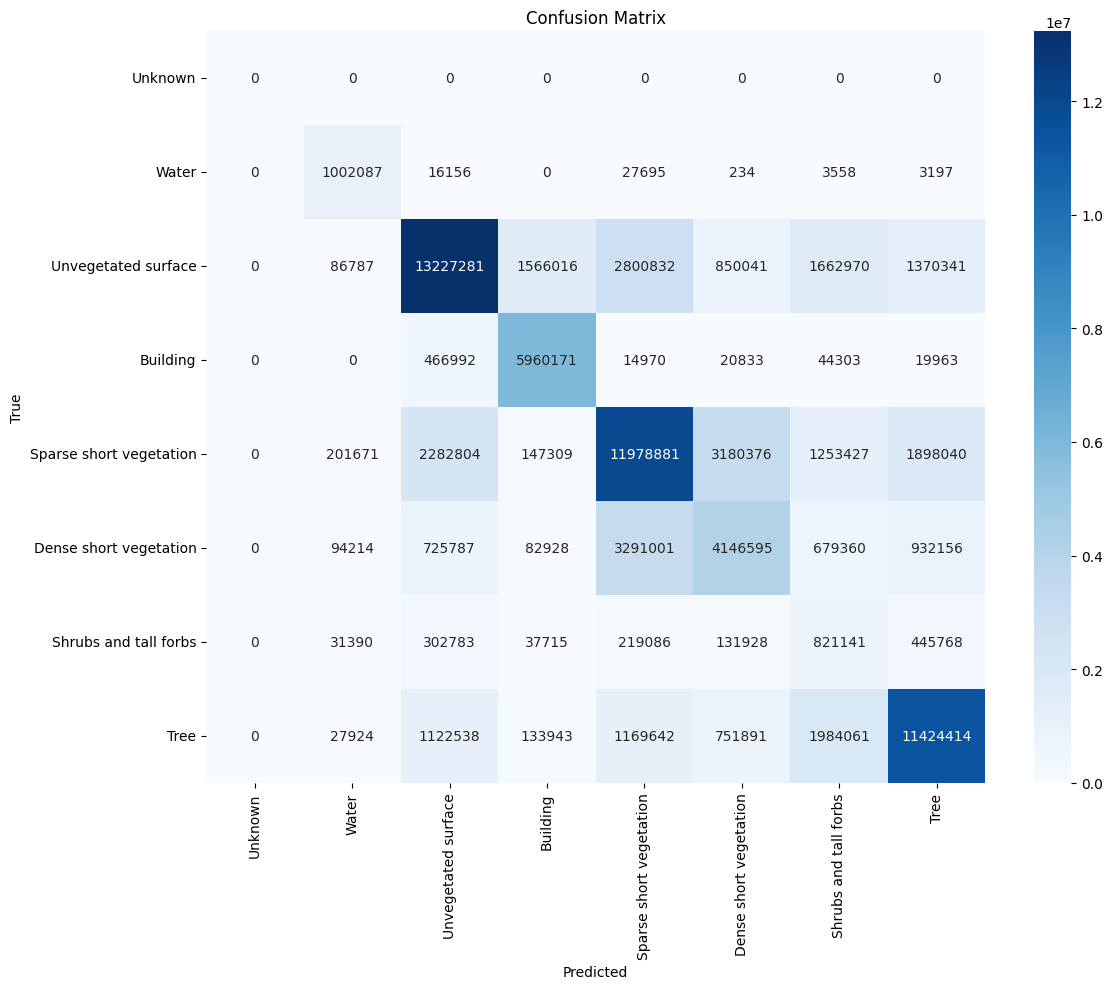

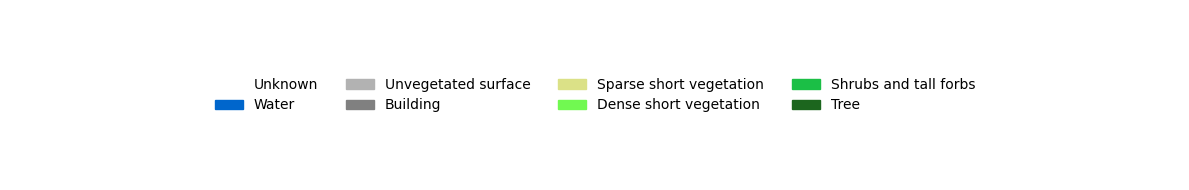

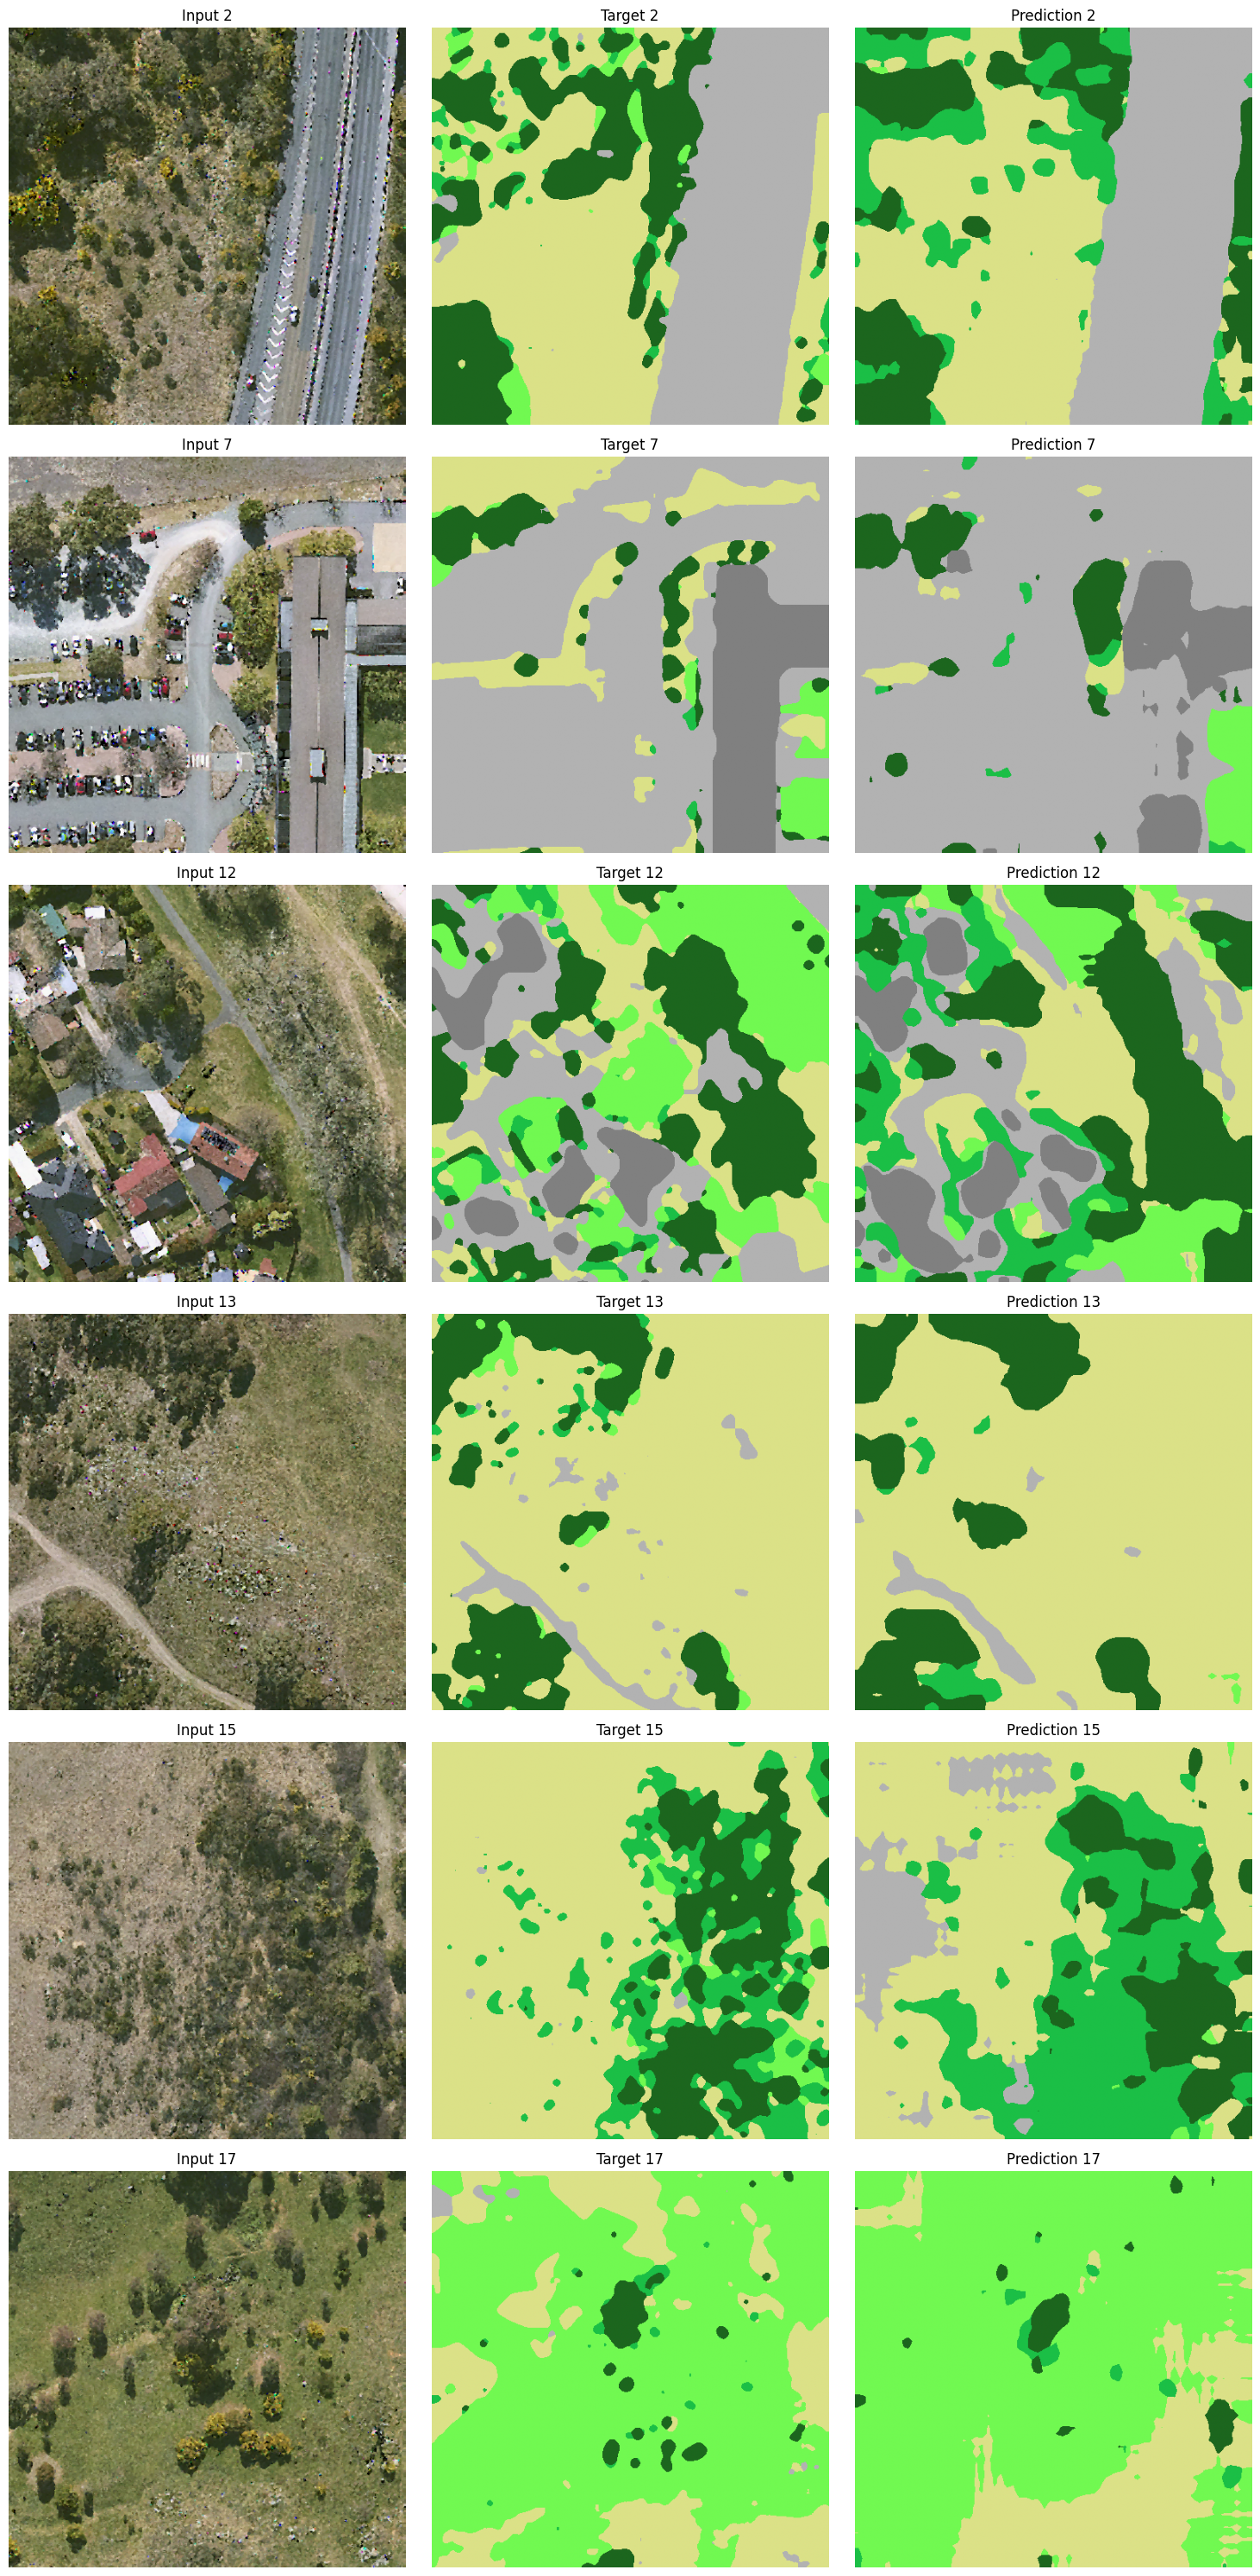

In [6]:
def evaluate_predictions(predictions, targets):
    """
    Compute pixel-wise accuracy for the entire dataset
    """
    # Convert list of tensors to flat tensors
    pred_flat = torch.cat([p.view(-1) for p in predictions])
    targets_flat = torch.cat([t.view(-1) for t in targets])

    # Compute correct predictions and accuracy
    correct = (pred_flat == targets_flat).sum().item()
    total = targets_flat.numel()
    accuracy = correct / total * 100

    print(f'Pixel-wise Accuracy: {accuracy:.2f}%')
    return accuracy

def compute_metrics(predictions, targets, num_classes=8):
    """
    Compute confusion matrix and F1 scores
    """
    # Flatten predictions and targets
    pred_flat = torch.cat(predictions).view(-1).cpu().numpy()
    targets_flat = torch.cat(targets).view(-1).cpu().numpy()
    
    # Compute confusion matrix
    cm = confusion_matrix(targets_flat, pred_flat, labels=range(num_classes))
    
    # Compute macro F1 score
    f1_macro = f1_score(targets_flat, pred_flat, labels=range(num_classes), average='macro')
    
    # Compute per-class F1 scores
    f1_per_class = f1_score(targets_flat, pred_flat, labels=range(num_classes), average=None)
    
    return cm, f1_macro, f1_per_class

def plot_confusion_matrix(cm, class_names):
    """
    Plot confusion matrix as a heatmap
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

def plot_rgb_target_prediction(inputs, targets, predictions, indices, custom_colors):
    """
    Plot RGB input, target, and prediction side by side
    """
    fig, axs = plt.subplots(len(indices), 3, figsize=(15, 5 * len(indices)))
    custom_cmap = mcolors.ListedColormap(custom_colors)
    
    if len(indices) == 1:
        axs = axs.reshape(1, -1)
    
    for i, idx in enumerate(indices):
        # Plot input (RGB)
        rgb_input = inputs[idx].cpu()
        if len(rgb_input.shape) == 4:  # Handle batch dimension
            rgb_input = rgb_input[0]
        rgb_input = rgb_input[:3].permute(1, 2, 0)
        rgb_input = (rgb_input - rgb_input.min()) / (rgb_input.max() - rgb_input.min())
        axs[i, 0].imshow(rgb_input)
        axs[i, 0].set_title(f"Input {idx}")
        axs[i, 0].axis('off')
        
        # Plot target
        target = targets[idx].cpu()
        if len(target.shape) == 3:  # Handle batch dimension
            target = target[0]
        axs[i, 1].imshow(target, cmap=custom_cmap, vmin=0, vmax=7)
        axs[i, 1].set_title(f"Target {idx}")
        axs[i, 1].axis('off')
        
        # Plot prediction
        pred = predictions[idx].cpu()
        if len(pred.shape) == 3:  # Handle batch dimension
            pred = pred[0]
        axs[i, 2].imshow(pred, cmap=custom_cmap, vmin=0, vmax=7)
        axs[i, 2].set_title(f"Prediction {idx}")
        axs[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

def generate_class_label_legend(class_names, custom_colors):
    """
    Generate a legend showing class names and their corresponding colors
    """
    fig, ax = plt.subplots(figsize=(12, 2))
    ax.axis('off')
    
    patches = [mpatches.Patch(color=custom_colors[i], label=class_names[i]) 
              for i in range(len(class_names))]
    ax.legend(handles=patches, loc='center', ncol=4, frameon=False)
    
    plt.tight_layout()
    plt.show()

# Example usage
def evaluate_model(inputs, predictions, targets):
    # Define class names and colors
    class_names = ['Unknown', 'Water', 'Unvegetated surface', 'Building', 
                  'Sparse short vegetation', 'Dense short vegetation', 
                  'Shrubs and tall forbs', 'Tree']
    
    custom_colors = ["#FFFFFF", "#0066CC", "#B2B2B2", "#808080", 
                    "#DBE187", "#71F951", "#1BBF46", "#1C661E"]
    
    # Calculate and print pixel-wise accuracy
    accuracy = evaluate_predictions(predictions, targets)
    
    # Compute and display metrics
    cm, f1_macro, f1_per_class = compute_metrics(predictions, targets)
    print(f"\nMacro F1 Score: {f1_macro:.4f}")
    
    # Print per-class F1 scores
    print("\nPer-class F1 scores:")
    for i, f1 in enumerate(f1_per_class):
        print(f"{class_names[i]}: {f1:.4f}")
    
    # Plot confusion matrix
    plot_confusion_matrix(cm, class_names)
    
    # Generate class label legend
    generate_class_label_legend(class_names, custom_colors)
    
    # Plot sample predictions
    # Select a subset of indices for visualization
    indices = [2, 7, 12, 13, 15, 17]
    plot_rgb_target_prediction(inputs, targets, predictions, indices, custom_colors)


evaluate_model(inputs, predictions, targets)

In [7]:
import torch
import torch.onnx
import onnx
from onnxconverter_common import float16
from torchvision.models.segmentation import deeplabv3_resnet101
import torch.nn as nn

class DeepLabV3CLF(nn.Module):
    def __init__(self, num_classes=8, pretrained=False):
        super(DeepLabV3CLF, self).__init__()
        # Load pretrained DeepLabV3+ without auxiliary classifier
        self.model = deeplabv3_resnet101(pretrained=False, aux_loss=False)
        
        # Modify the classifier to output your number of classes
        self.model.classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=1)
        
    def forward(self, x):
        # For ONNX export, we only return the 'out' tensor
        result = self.model(x)
        return result['out']

def export_to_onnx(model_path, output_path, fp16=True):
    # Initialize model without auxiliary classifier
    model = DeepLabV3CLF(num_classes=8, pretrained=False)
    
    # Load trained weights
    state_dict = torch.load(model_path)
    
    # Filter out auxiliary classifier weights
    filtered_state_dict = {k: v for k, v in state_dict.items() 
                          if not k.startswith('model.aux_classifier')}
    
    # Load the filtered state dict
    model.load_state_dict(filtered_state_dict)
    model.eval()
    model = model.to('cuda')
    
    # Create dummy input
    dummy_input = torch.randn(1, 3, 256, 256, device='cuda')
    
    # Export to ONNX
    torch.onnx.export(model,
                     dummy_input,
                     output_path,
                     export_params=True,
                     opset_version=19,
                     do_constant_folding=True,
                     input_names=['input'],
                     output_names=['output'],
                     dynamic_axes={'input': {0: 'batch_size', 2: "height", 3: "width"},
                                 'output': {0: 'batch_size', 2: "height", 3: "width"}})
    
    print(f"Model exported to {output_path}")
    
    if fp16:
        # Load the ONNX model
        onnx_model = onnx.load(output_path)
        
        # Convert to FP16
        onnx_model_fp16 = float16.convert_float_to_float16(
            onnx_model,
            keep_io_types=False,
            op_block_list=None,
        )
        
        # Save the FP16 model
        fp16_path = output_path.replace('.onnx', '_fp16.onnx')
        onnx.save(onnx_model_fp16, fp16_path)
        
        # Verify the model
        print(onnx.checker.check_model(onnx_model_fp16))
        print(f"FP16 model saved to {fp16_path}")

model_path = "/home/haizea-gpu-machine-1/Desktop/actclf/act23_v5.pth"
output_path = "act23_v5.onnx"
export_to_onnx(model_path, output_path, fp16=True)



/home/haizea-gpu-machine-1/miniconda3/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/haizea-gpu-machine-1/miniconda3/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_2344771/2794529302.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the d

Model exported to act23_v5.onnx


/home/haizea-gpu-machine-1/miniconda3/envs/fastai/lib/python3.10/site-packages/onnxconverter_common/float16.py:43: UserWarning: the float32 number 9.49315070767401e-18 will be truncated to 1e-07
  warnings.warn("the float32 number {} will be truncated to {}".format(pos_min, min_positive_val))
/home/haizea-gpu-machine-1/miniconda3/envs/fastai/lib/python3.10/site-packages/onnxconverter_common/float16.py:53: UserWarning: the float32 number -1.1443621137076912e-19 will be truncated to -1e-07
  warnings.warn("the float32 number {} will be truncated to {}".format(neg_max, -min_positive_val))
/home/haizea-gpu-machine-1/miniconda3/envs/fastai/lib/python3.10/site-packages/onnxconverter_common/float16.py:53: UserWarning: the float32 number -8.930300054998952e-09 will be truncated to -1e-07
  warnings.warn("the float32 number {} will be truncated to {}".format(neg_max, -min_positive_val))
/home/haizea-gpu-machine-1/miniconda3/envs/fastai/lib/python3.10/site-packages/onnxconverter_common/float16.p

None
FP16 model saved to act23_v5_fp16.onnx


gsutil cp /home/haizea-gpu-machine-1/Desktop/actclf/act23_v5_fp16.onnx gs://terrakio-models

In [ ]:
class LocalDataset(Dataset):
    '''Read samples from a local directory'''
    def __init__(self, rgb_dir, label_dir, file_names):
        self.rgb_dir = rgb_dir
        self.label_dir = label_dir
        self.file_names = file_names

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        input_data, target_data = self.load_data(self.file_names[idx])
        return {'inputs': input_data, 'target': target_data}

    def load_data(self, file_name):
        rgb_path = os.path.join(self.rgb_dir, file_name)
        label_path = os.path.join(self.label_dir, file_name)
        with xr.open_dataset(rgb_path) as rgb, xr.open_dataset(label_path) as label:
            # 2004 rgb ds has dims (1,255,255), pad  to 256x256
            rgb = rgb.pad(x=(0, 1), y=(0, 1), mode='median')
            input_data = rgb[['var0', 'var1', 'var2']]
            
            target_data = label.label.values
        return input_data, target_data

def custom_collate(batch):
    """
    Custom collate function to handle xarray DataArrays in the batch using np.concatenate.
    """
    batch_inputs = [np.expand_dims(sample['inputs'].to_array().values, axis=0) for sample in batch]
    batch_targets = [np.expand_dims(sample['target'].to_array().values, axis=0) for sample in batch]
    # Concatenate and return tensors
    batch_inputs = np.concatenate(batch_inputs, axis=0)
    batch_targets = np.concatenate(batch_targets, axis=0)
    batch_inputs = torch.tensor(batch_inputs)
    batch_targets = torch.tensor(batch_targets)
    return {'inputs': batch_inputs, 'target': batch_targets}


rgb_dir = '/home/haizea-gpu-machine-2/Desktop/actclf/rgb23/ver1'
label_dir = '/home/haizea-gpu-machine-2/Desktop/actclf/labels15'
file_names = [f for f in os.listdir(label_dir) if f.endswith('.nc')]

train_size = 900
val_size = 200
test_size = 400

np.random.seed(12)
np.random.shuffle(file_names)
train_files = file_names[:train_size]
val_files = file_names[train_size:train_size + val_size]
test_files = file_names[train_size + val_size: train_size + val_size + test_size]

train_ds = LocalDataset(rgb_dir, label_dir, train_files)
val_ds = LocalDataset(rgb_dir, label_dir, val_files)
test_ds = LocalDataset(rgb_dir, label_dir, test_files)

train_loader = DataLoader(train_ds, batch_size=8, num_workers=4, collate_fn=custom_collate)
val_loader = DataLoader(val_ds, batch_size=8, num_workers=4, collate_fn=custom_collate)
test_loader = DataLoader(test_ds, batch_size=8, num_workers=4, collate_fn=custom_collate)